<a href="https://www.kaggle.com/code/sonnylowe/new-titanic-simple-deep-learning-tutorial?scriptVersionId=181016757" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Titanic - Simple Deep Learning Tutorial**

Welcome! This simple tutorial walks you through simple data processing and using Kera's Sequential framework to generate a deep neural network to model our data. You will learn basic concepts and develop a baseline model that is impressive in accuracy. Nevertheless, you are encouraged to experiment with the data and the model to generate a more accudate prediction. 

If you learned something, please upvote to support these types of tutorials!

By Sonny Lowe

# File Processing:
Reading the input file csv.

In [1]:
import numpy as np
import pandas as pd
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Data Processing:

Our data processing is split in two steps: one predefined custom function for the more complex data columns (ie name, ticket, etc), and then a processing keras pipeline for general numerical and categorical data. 

First, our custom function, called preprocess, isolates the prefix in a name (miss, mr, mrs) and places it into its own column. It also splits the ticket into the ticket number and its class (item).

Finally, we will split the data into two sections, **training** and **validation**. The size of the training versus validation sections can be specified through the *train_size* property.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

file_path = '../input/titanic/train.csv'
data = pd.read_csv(file_path)
data.head()

X = data.copy()
y = X.Survived

def preprocess(df):
    df = df.copy()
    
    def prefix(x):
        name = x.split(",")
        return (name[1].split(" ")[1])[:-1]
    
    def normalize_name(x):
        name = " ".join([v.strip(",()[].\"'") for v in x.split(" ")])
        return name.split(" ")[0] + " " + " ".join(name.split(" ")[2:])
    
    def ticket_number(x):
        num = x.split(" ")[-1]
        if(num.isnumeric()):
            return num
        return 0
        
    def ticket_item(x):
        items = x.split(" ")
        if len(items) == 1:
            return "NONE"
        return "_".join(items[0:-1])
    
    df["Prefix"] = df["Name"].apply(prefix)
    df["Name"] = df["Name"].apply(normalize_name)
    df["Ticket_number"] = df["Ticket"].apply(ticket_number)
    df["Ticket_item"] = df["Ticket"].apply(ticket_item)
        
    return df

X = preprocess(X)

prefix_possibilities = X['Prefix'].unique()
print(prefix_possibilities)

X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.70)

X.head()

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'th' 'Jonkheer']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Prefix,Ticket_number,Ticket_item
0,1,0,3,Braund Owen Harris,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,21171,A/5
1,2,1,1,Cumings John Bradley Florence Briggs Thayer,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,17599,PC
2,3,1,3,Heikkinen Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,3101282,STON/O2.
3,4,1,1,Futrelle Jacques Heath Lily May Peel,female,35.0,1,0,113803,53.1000,C123,S,Mrs,113803,NONE
4,5,0,3,Allen William Henry,male,35.0,0,0,373450,8.0500,NaN,S,Mr,373450,NONE


The features are split into two cartegories for pipeline processing - **Numberical** and **Categorical**.
- A data **pipeline** takes in raw data and processes it into the desired format using a fixed framework
- This framework first **imputes** the numerical data by substituting missing data with a different value. Then it **scales** it to unit variance.
- For categorical data, it uses **OneHotEncoding** to transform categorical data to multiple columns of each possible unique entry, with a 0 if it exists and a 1 if it does not. See the diagram below:

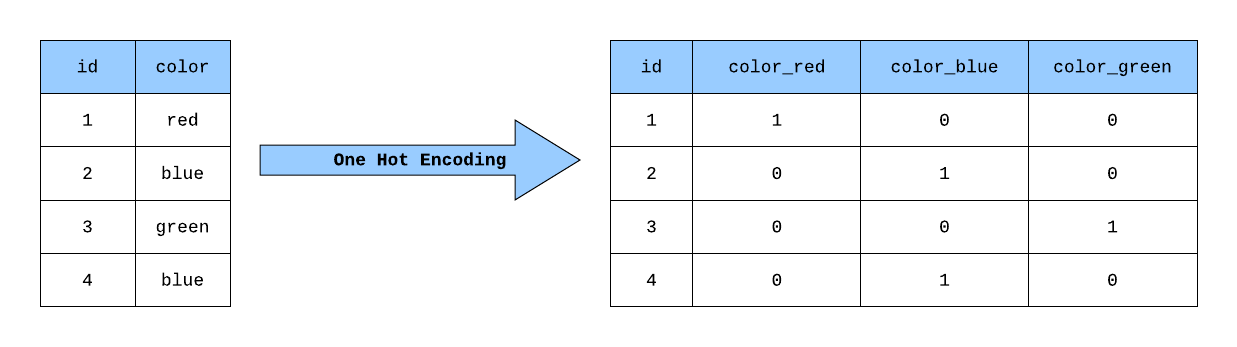

In [3]:
features_num = [
    'Pclass', 'Age', 'SibSp', 'Parch', 'Ticket_number'
]

features_cat = [
    'Sex', 'Embarked', 'Prefix'
]

# these are features that we want to keep but need not process. In this case, it is empty but feel free to add some
features_other = [
]

transformer_num = make_pipeline(
    SimpleImputer(),
    StandardScaler()
)

transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore', sparse_output=False),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
    ('passthrough', features_other)
)

processed_X_train = preprocessor.fit_transform(X_train)
processed_X_valid = preprocessor.transform(X_valid)

df = pd.DataFrame(X_train)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Prefix,Ticket_number,Ticket_item
600,601,1,2,Jacobsohn Sidney Samuel Amy Frances Christy,female,24.0,2,1,243847,27.0000,NaN,S,Mrs,243847,NONE
792,793,0,3,Sage Stella Anna,female,NaN,8,2,CA. 2343,69.5500,NaN,S,Miss,2343,CA.
34,35,0,1,Meyer Edgar Joseph,male,28.0,1,0,PC 17604,82.1708,NaN,C,Mr,17604,PC
6,7,0,1,McCarthy Timothy J,male,54.0,0,0,17463,51.8625,E46,S,Mr,17463,NONE
53,54,1,2,Faunthorpe Lizzie Elizabeth Anne Wilkinson,female,29.0,1,0,2926,26.0000,NaN,S,Mrs,2926,NONE


# Model
Using Keras, we will create the structure of our neural network. Determining the amount of layers, dropout layers, and batch normalizations is a complex process, and you are encouraged to experiment with the structure. The given structure is by no means an optimal one.

This model uses two basic types of layers
- **Dense layers:** these are the most basic layers of a neural network that are composed of nodes (neurons) that take inputs and linearly alters it to an output (very simplified explanation). Then, they each will have an activation function that essentially places a kink in the linearly path to allow the model to stray from pure line.
- **Dropout Layers:** A dropout layer is a layer in a neural network that randomly sets some input units to zero during training to help prevent overfitting. This is done with a defined probability, or rate, which is specified through the *rate* property.

You may also experiment with batch normalization layers:
- **Batch Normalization:** Batch normalization is a technique that normalizes the inputs of each layer in a deep neural network to improve training speed and stability.

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

This model's goal is a binary output - 0 for death and 1 for survival. Therefore, when **compiling** this model, we can specify our loss function and metric to be of binary nature. A loss function is the function that the model will attempt to minimize, which can be thought of as a measure of departure from accuracy. Obviously, we will attempt to minimize this departure.

In addition, to prevent overfitting, we have an **early_stopping** function. Essentially, we can specify how many epochs to wait (*patience*) without a minimum improvement (*min_delta*) in order to prematurely stop the compilation. You can play around with these properties too.

Finally, we will track the **history** of our model and how many *epochs* (versions) to run it for. This number is unnecessarily large, as we are relying on our early stopping function to terminate the running. You can also change the batch_sizes, which is how much data it looks at for each iteration in an epoch. (Every epoch is made of many iterations towards the best possible accuracy)

In [6]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    processed_X_train, y_train,
    validation_data=(processed_X_valid, y_valid),
    batch_size=512,
    epochs=100,
    callbacks=[early_stopping],
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - binary_accuracy: 0.5568 - loss: 0.6841 - val_binary_accuracy: 0.6157 - val_loss: 0.6112
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - binary_accuracy: 0.6140 - loss: 0.6213 - val_binary_accuracy: 0.6716 - val_loss: 0.5427
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - binary_accuracy: 0.6461 - loss: 0.5685 - val_binary_accuracy: 0.8246 - val_loss: 0.4797
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - binary_accuracy: 0.7897 - loss: 0.5126 - val_binary_accuracy: 0.8433 - val_loss: 0.4531
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - binary_accuracy: 0.7919 - loss: 0.4755 - val_binary_accuracy: 0.8507 - val_loss: 0.4222
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - binary_accuracy: 0.8067 - loss: 0.4408 - val_binary_accuracy: 0.8507 - val_loss: 0.4108
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - binary_accuracy: 0.8162 - loss: 0.4195 - val_binary_accuracy: 0.8507 - val_loss: 0.4098
Epoch 8/100
2/2 ━━━

Now, we can plot this history.

Best Validation Loss: 0.4098
Best Validation Accuracy: 0.8507


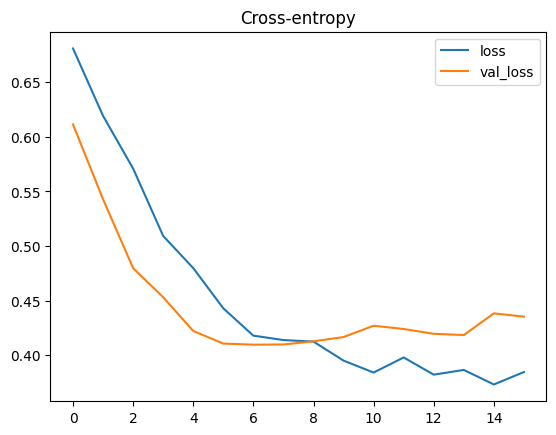

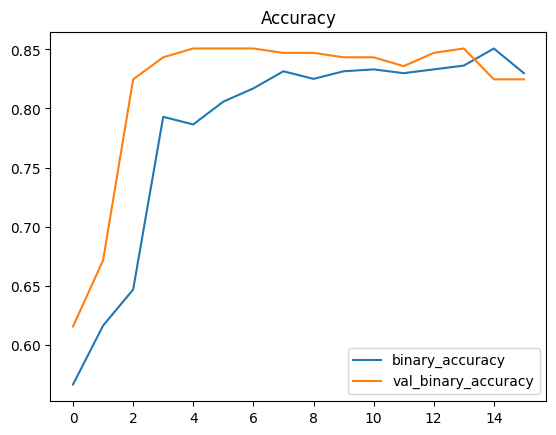

In [7]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

# Predicting

Using our established data processing pipeline, we can process the given testing data. Then, we will use the model with the best accuracy across epochs, as our early stopping function tracks, to determine predictions.

The final step is writing the predictions into an output file to submit. It is now ur job to get a better score than we have here! Good Luck!

In [104]:
subm_path = '../input/titanic/test.csv'

data = pd.read_csv(subm_path)
test_data = data.copy()

test_data = preprocess(test_data)
test_data = preprocessor.transform(test_data)

final_preds = np.round(np.clip(model.predict(test_data), 0, 1))

output = pd.DataFrame({
    'PassengerId': data.PassengerId,
    'Survived': final_preds[:, 0].astype(int)
})

#uncomment the below lines to write the output into your submission file. We will experiment further however.
#output.to_csv('submission.csv', index=False)

#output = pd.read_csv('submission.csv')
#output.head()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


# Hyperparameter Tuning
In this section, we will experiment with different parameters to find the best combination for this dataset. There are certain tools we can use to make it easier for us (**keras Tuner**, grid search, random search, etc).

In this example, we will use the Keras Tuner to tune many different parameters including:
- **number of dense layers**
- **presence of dropout layers**
- **dense unit count**
- **dropout rate**
- **activation function**
- **optimizer**

Given the relatively small dataset, the parameters might not make a huge difference. However, this is still a very useful skill to learn when applying it to larger more complex datasets.

In [8]:
import keras_tuner
from tensorflow import keras
from tensorflow.keras import layers


def build_model(hp):
    model = keras.Sequential()
    
    for i in range(hp.Int("num_layers", 1, 2)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(0.2))
        
    for i in range(hp.Int("num_layers", 1, 2)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(0.2))
    
    model.add(layers.Dense(1, activation="sigmoid"))
    
    model.compile(
        optimizer=hp.Choice("optimizer", ['adam', 'sgd', 'rmsprop']),
        loss="binary_crossentropy",
        metrics=["binary_accuracy"],
    )
    return model

# testing if it builds successfully (expected: <Sequential name=sequential_#, built=False>)
build_model(keras_tuner.HyperParameters())

<Sequential name=sequential_2, built=False>

Now, we will actually begin the tuner using a random search and some specified parameters. The important ones to take note of here are the max_trials and executions per trial. Similar to a lab experiement, each trial has different parameters. However, due to the variance inherent within the models, we can choose to execute each trial multiple times. Here is a more comprehensive tutorial on hyperparameter tuning: [https://keras.io/guides/keras_tuner/getting_started/](http://)

In [12]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="binary_accuracy",
    max_trials=15,
    executions_per_trial=3,
    overwrite=True
)

# confirming the parameters of our search
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd', 'rmsprop'], 'ordered': False}


Actually starting the search! This will take a while depending on how many trials you put. After it has searched, we can ask it to give us a summary of the best models and their respective parameters.

In [14]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

tuner.search(processed_X_train, y_train, epochs=100, batch_size=512, validation_data=(processed_X_valid, y_valid), callbacks=[early_stopping], verbose=0)
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="binary_accuracy", direction="max")

Trial 14 summary
Hyperparameters:
num_layers: 2
units_0: 512
activation: relu
dropout: False
optimizer: adam
units_1: 512
Score: 0.8507223129272461

Trial 03 summary
Hyperparameters:
num_layers: 2
units_0: 224
activation: relu
dropout: False
optimizer: adam
units_1: 32
Score: 0.8426966269810995

Trial 05 summary
Hyperparameters:
num_layers: 2
units_0: 32
activation: relu
dropout: True
optimizer: adam
units_1: 192
Score: 0.8314606746037801

Trial 06 summary
Hyperparameters:
num_layers: 1
units_0: 512
activation: relu
dropout: False
optimizer: rmsprop
units_1: 160
Score: 0.8309256235758463

Trial 10 summary
Hyperparameters:
num_layers: 2
units_0: 224
activation: tanh
dropout: False
optimizer: adam
units_1: 448
Score: 0.8309256235758463

Trial 01 summary
Hyperparameters:
num_layers: 1
units_0: 64
activation: relu
dropout: False
optimizer: adam
Score: 0.8298555413881937


Next, we can isolate the best model and ask for its parameters.

In [15]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 801,793 (3.06 MB)

 Trainable params: 801,793 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

Finally, we will use these found best parameters to retrain the model on the entire dataset to be used for submission.

In [24]:
# Get the top hyperparameter
best_hps = tuner.get_best_hyperparameters()[0]
final_model = build_model(best_hps)

x_all = np.concatenate((processed_X_train, processed_X_valid))
y_all = np.concatenate((y_train, y_valid))

final_model.fit(x_all, y_all, epochs=30)

subm_path = '../input/titanic/test.csv'

data = pd.read_csv(subm_path)
test_data = data.copy()

test_data = preprocess(test_data)
test_data = preprocessor.transform(test_data)

final_preds = np.round(np.clip(final_model.predict(test_data), 0, 1))

output = pd.DataFrame({
    'PassengerId': data.PassengerId,
    'Survived': final_preds[:, 0].astype(int)
})

#uncomment the below lines to write the output into your submission file. We will experiment further however.
output.to_csv('submission.csv', index=False)

output = pd.read_csv('submission.csv')
output.head()

Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - binary_accuracy: 0.7414 - loss: 0.5392
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.8173 - loss: 0.4261
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.8461 - loss: 0.3656
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.8517 - loss: 0.3751
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.8551 - loss: 0.3704
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.8406 - loss: 0.3706
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.8612 - loss: 0.3583
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.8675 - loss: 0.3508
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.8583 - loss: 0.3619
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.8593 - loss: 0.3697
Epoch 11/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.8685 - loss: 0.33

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# Bonus Section
Taking the Majority Guess of Many Models without using hyperparameterization.

In [94]:
def train_model(X, y, test_data):

    X_train, X_valid, p_y_train, p_y_valid = \
        train_test_split(X, y, stratify=y, train_size=0.75)
    
    p_X_train = preprocessor.fit_transform(X_train)
    p_X_valid = preprocessor.transform(X_valid)
    pred_data = test_data.copy()
    pred_data = preprocessor.transform(pred_data)
    
    new_model = keras.Sequential([
        layers.Dense(256, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dropout(rate=0.2),
        layers.Dense(256, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dropout(rate=0.2),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid'),
    ])
    new_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy'],
    )
    early_stopping = keras.callbacks.EarlyStopping(
        patience=10,
        min_delta=0.001,
        restore_best_weights=True,
    )
    new_history = new_model.fit(
        p_X_train, p_y_train,
        validation_data=(p_X_valid, p_y_valid),
        batch_size=512,
        epochs=100,
        callbacks=[early_stopping],
        verbose=0
    )

    preds = np.round(np.clip(new_model.predict(pred_data), 0, 1))
    histories.append(new_history)
    return preds
    

In [95]:
histories = []

file_path = '../input/titanic/train.csv'
data = pd.read_csv(file_path)

X = data.copy()
y = X.Survived
X = preprocess(X)

subm_path = '../input/titanic/test.csv'
test_data = pd.read_csv(subm_path)
test_data = preprocess(test_data)

# arrays to track the number of predictions for a passenger to have died or survived
# the final prediction will be determined by which prediction is more frequent with tiebreaks for dying
dead = []
survived = []

# change the range for how many models you want to create - the more models the more time
# uncomment the below to run the compilation
#for x in range(9):
#    preds = train_model(X, y, test_data)
#        
#    for i in range(0, len(preds)):
#        if(x == 0):
#            if (preds[i] == 0):
#                dead.append(1)
#                survived.append(0)
#            else:
#                dead.append(0)
#                survived.append(1)
#        else:
#             if (preds[i] == 0):
#                 dead[i] += 1
#             else:
#                 survived[i] += 1

# print("Binary Accuracies:")
# for x in range(0, len(histories)):
#     history_df = pd.DataFrame(histories[x].history)
#     print(history_df['val_binary_accuracy'].max())

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Binary Accuracies:
0.8385650515556335
0.8609865307807922
0.8116592168807983
0.8430493474006653
0.8116592168807983


In [96]:
# final_preds = []

# for i in range(0, len(dead)):
#     if(dead[i] >= survived[i]):
#         final_preds.append(0)
#     else:
#         final_preds.append(1)
        
# output = pd.DataFrame({
#     'PassengerId': test_data.PassengerId,
#     'Survived': final_preds
# })

# output.to_csv('submission.csv', index=False)

# output = pd.read_csv('submission.csv')
# output.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
